In [1]:
import os
import warnings
import sys
import codecs
import numpy as np
import argparse
import json
import pickle

from util import read_passages, evaluate, make_folds, clean_words, test_f1, to_BIO, from_BIO, from_BIO_ind, arg2param

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1.0
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(config=config)
import keras.backend as K
K.set_session(sess)
from keras.activations import softmax
from keras.regularizers import l2
from keras.models import Model, model_from_json
from keras.layers import Input, LSTM, Dense, Dropout, TimeDistributed, Bidirectional
from keras.callbacks import EarlyStopping,LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam, RMSprop, SGD
from crf import CRF
from attention import TensorAttention
from custom_layers import HigherOrderTimeDistributedDense
from generator import BertDiscourseGenerator
from keras_bert import load_trained_model_from_checkpoint, Tokenizer

from discourse_tagger_generator_bert import PassageTagger

import matplotlib.pyplot as plt
from scipy.special import softmax
from matplotlib import transforms

Using TensorFlow backend.


In [2]:
use_attention = True
att_context = "LSTM_clause"
bidirectional = bid = True
crf = True
lstm = False
maxseqlen = 40
maxclauselen = 60
input_size = 768
embedding_dropout=0.4 
high_dense_dropout=0.4
attention_dropout=0.6
lstm_dropout=0.5
word_proj_dim=300 
hard_k=0 
lstm_dim = 350 
rec_hid_dim = 75 
att_proj_dim = 200 
batch_size = 10
reg=0


In [3]:
prefix="scidt_scibert/"
model_ext = "att=%s_cont=%s_lstm=%s_bi=%s_crf=%s"%(str(use_attention), att_context, str(lstm), str(bid), str(crf))
model_config_file = open(prefix+"model_%s_config.json"%model_ext, "r")
model_weights_file_name = prefix+"model_%s_weights"%model_ext
model_label_ind = prefix+"model_%s_label_ind.json"%model_ext
label_ind_json = json.load(open(model_label_ind))
label_ind = {k: int(label_ind_json[k]) for k in label_ind_json}
num_classes = len(label_ind)

In [4]:
if use_attention:
    inputs = Input(shape=(maxseqlen, maxclauselen, input_size))
    x = Dropout(embedding_dropout)(inputs)
    x = HigherOrderTimeDistributedDense(input_dim=input_size, output_dim=word_proj_dim, reg=reg)(x)
    att_input_shape = (maxseqlen, maxclauselen, word_proj_dim)
    x = Dropout(high_dense_dropout)(x)
    x, raw_attention = TensorAttention(att_input_shape, context=att_context, hard_k=hard_k, proj_dim = att_proj_dim, rec_hid_dim = rec_hid_dim, return_attention=True)(x)
    x = Dropout(attention_dropout)(x)
else:
    inputs = Input(shape=(maxseqlen, input_size))
    x = Dropout(embedding_dropout)(inputs)
    x = TimeDistributed(Dense(input_dim=input_size, units=word_proj_dim))

if bidirectional:
    x = Bidirectional(LSTM(input_shape=(maxseqlen,word_proj_dim), units=lstm_dim, 
                                  return_sequences=True,kernel_regularizer=l2(reg),
                                  recurrent_regularizer=l2(reg), 
                                  bias_regularizer=l2(reg)))(x)
    x = Dropout(lstm_dropout)(x) 
elif lstm:
    x = LSTM(input_shape=(maxseqlen,word_proj_dim), units=lstm_dim, return_sequences=True,
                    kernel_regularizer=l2(reg),
                    recurrent_regularizer=l2(reg), 
                    bias_regularizer=l2(reg))(x)
    x = Dropout(lstm_dropout)(x) 

if crf:
    Crf = CRF(num_classes,learn_mode="join")
    discourse_prediction = Crf(x)
    tagger = Model(inputs=inputs, outputs=[discourse_prediction])        
else:
    discourse_prediction = TimeDistributed(Dense(num_classes, activation='softmax'),name='discourse')(x)
    tagger = Model(inputs=inputs, outputs=[discourse_prediction])

In [5]:
tagger.load_weights(model_weights_file_name)


In [6]:
if crf:
    tagger.compile(optimizer=Adam(), loss=Crf.loss_function, metrics=[Crf.accuracy])
else:
    tagger.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [7]:
inp = tagger.input
attention_output = tagger.layers[4].output[1]

In [8]:
functor = K.function([inp, K.learning_phase()], [attention_output])

In [9]:
test_file = "lucky_test.txt"

In [10]:
params = {
    "repfile":"/nas/home/xiangcil/scibert_scivocab_uncased",
    "use_attention": True,
    "batch_size": 10,
    "maxseqlen": 40,
    "maxclauselen": 60
         }

In [11]:
pretrained_path = params["repfile"]
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

bert = load_trained_model_from_checkpoint(config_path, checkpoint_path)
bert._make_predict_function() # Crucial step, otherwise TF will give error.

token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)
tokenizer = Tokenizer(token_dict)  

In [12]:
str_seqs, label_seqs = read_passages(test_file, is_labeled=True)
str_seqs = clean_words(str_seqs)
label_seqs = to_BIO(label_seqs)

In [13]:
bert_generator = BertDiscourseGenerator(bert, tokenizer, str_seqs, label_seqs, label_ind, 10, True, 40, 60, True, input_size=768)

In [14]:
test_X, test_Y = bert_generator.make_data(str_seqs, label_seqs)

In [15]:
attention_raw_scores = functor([test_X])[0]

In [16]:
attention_scores = softmax(attention_raw_scores,axis=-1)

In [17]:
reverse_token_dict = {v:k for k,v in token_dict.items()}

In [18]:
str_seqs_tokenized = []
for str_seq in str_seqs:
    str_seq_tokenized = []
    for clause in str_seq:
        clause_tokenized = []
        indices, segments = tokenizer.encode(clause.lower(), max_len=512)
        for i in range(60):
            clause_tokenized.append(reverse_token_dict[indices[i]])
        str_seq_tokenized.append(clause_tokenized)
    str_seqs_tokenized.append(str_seq_tokenized)

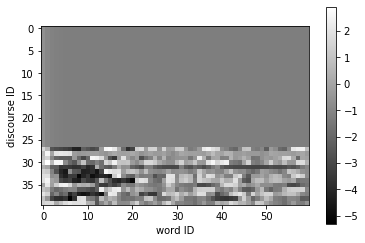

In [19]:
plt.figure()
plt.imshow(attention_raw_scores[0,:,:],cmap='gray',aspect="equal",interpolation='none')
plt.ylabel("discourse ID")
plt.xlabel("word ID")
plt.colorbar()
plt.show()

In [20]:
goal_string = str_seqs_tokenized[5][-5][1:10]
goal_weight = attention_raw_scores[5,-5,1:10]

In [21]:
# goal
for token, weight in zip(str_seqs_tokenized[5][-5], attention_scores[5,-5,:]):
    print(token, weight)

[CLS] 0.013400033
to 0.31812173
further 0.1630611
test 0.054072104
the 0.00474126
function 0.0029656326
of 0.00039091977
rag 0.00032799493
in 0.0008577317
autophagy 0.0020636402
[SEP] 0.0064929314
[PAD] 0.004492862
[PAD] 0.010073828
[PAD] 0.009908647
[PAD] 0.0010647355
[PAD] 0.00067480846
[PAD] 0.0011975939
[PAD] 0.0011656365
[PAD] 0.0030189175
[PAD] 0.03283101
[PAD] 0.0044681006
[PAD] 0.004780543
[PAD] 0.0006753908
[PAD] 0.0004371016
[PAD] 0.0011385672
[PAD] 0.00093250297
[PAD] 0.0022924033
[PAD] 0.00216708
[PAD] 0.0033607858
[PAD] 0.00054277485
[PAD] 0.0005099491
[PAD] 0.0009743285
[PAD] 0.0018046363
[PAD] 0.009933185
[PAD] 0.018062154
[PAD] 0.02046034
[PAD] 0.0035980484
[PAD] 0.0065378146
[PAD] 0.035535365
[PAD] 0.058377814
[PAD] 0.1129405
[PAD] 0.005661178
[PAD] 0.005394397
[PAD] 0.0008643695
[PAD] 0.00039725823
[PAD] 0.0007317628
[PAD] 0.00077280524
[PAD] 0.0019024039
[PAD] 0.0019956538
[PAD] 0.0020316269
[PAD] 0.00081582635
[PAD] 0.0011760269
[PAD] 0.0015746099
[PAD] 0.010288909


In [22]:
method_string = str_seqs_tokenized[5][-4][1:12]
method_weight = attention_raw_scores[5,-4,1:12]

In [23]:
# method
for token, weight in zip(str_seqs_tokenized[5][-4], attention_scores[5,-4,:]):
    print(token, weight)

[CLS] 0.03230634
we 0.06575207
examined 0.062973045
the 0.004083869
lc 0.0010154053
##3 0.0011969145
modification 0.0038189052
in 0.014905101
hek 0.0010344912
##293 0.0021147772
cells 0.008637033
. 0.0021345052
[SEP] 0.020099903
[PAD] 0.0073203994
[PAD] 0.0546677
[PAD] 0.016637152
[PAD] 0.038170848
[PAD] 0.008206516
[PAD] 0.0064173504
[PAD] 0.0031112304
[PAD] 0.0032729267
[PAD] 0.0049326182
[PAD] 0.010613975
[PAD] 0.019414006
[PAD] 0.007973953
[PAD] 0.0031304061
[PAD] 0.002765525
[PAD] 0.002671625
[PAD] 0.00341922
[PAD] 0.011053072
[PAD] 0.011468555
[PAD] 0.010722521
[PAD] 0.015724737
[PAD] 0.004101904
[PAD] 0.0035599133
[PAD] 0.020902833
[PAD] 0.04571804
[PAD] 0.03834991
[PAD] 0.0656269
[PAD] 0.090605825
[PAD] 0.011266035
[PAD] 0.0014124743
[PAD] 0.0023323148
[PAD] 0.008826168
[PAD] 0.01990922
[PAD] 0.006161961
[PAD] 0.002504559
[PAD] 0.0025769095
[PAD] 0.0020608632
[PAD] 0.020684073
[PAD] 0.025546812
[PAD] 0.015133109
[PAD] 0.0144009255
[PAD] 0.0041189087
[PAD] 0.0035342737
[PAD] 0.0

In [50]:
results_string = str_seqs_tokenized[5][-3][1:14]
results_weight = attention_raw_scores[5,-3,1:14]

In [40]:
results_string = str_seqs_tokenized[34][-6][1:21]
results_weight = attention_raw_scores[34,-6,1:21]

In [25]:
results_weight

array([ 0.86675406, -1.7732067 , -2.9266357 , -2.808795  , -2.9671485 ,
       -3.4789515 , -4.326325  , -3.5734642 ,  0.39682147,  2.1762378 ,
       -0.93599564, -0.57774717, -0.35994554], dtype=float32)

In [26]:
# results
for token, weight in zip(str_seqs_tokenized[5][-3], attention_scores[5,-3,:]):
    print(token, weight)

[CLS] 0.08107085
expression 0.031627353
of 0.0022570565
rag 0.0007122207
##a 0.0008012945
ql 0.0006839431
and 0.0004099651
rag 0.00017568597
##c 0.0003729928
sn 0.0197685
inhibited 0.11715596
lc 0.005213611
##3 0.0074597425
conversion 0.009275003
in 0.009368172
response 0.01728051
to 0.011764066
amino 0.0013677689
acid 0.0029441456
starvation 0.008441797
( 0.05665356
fig 0.07855153
. 0.007413407
7 0.002268498
##e 0.0044586915
) 0.014881012
. 0.0032192192
[SEP] 0.051463254
[PAD] 0.010603226
[PAD] 0.016779572
[PAD] 0.023665426
[PAD] 0.039294302
[PAD] 0.012387581
[PAD] 0.0038096986
[PAD] 0.0073135644
[PAD] 0.0047938623
[PAD] 0.043167155
[PAD] 0.049979344
[PAD] 0.01702229
[PAD] 0.014287903
[PAD] 0.0039117914
[PAD] 0.005558258
[PAD] 0.001734003
[PAD] 0.0033897734
[PAD] 0.0016695977
[PAD] 0.001070946
[PAD] 0.0048521985
[PAD] 0.003954503
[PAD] 0.0045268675
[PAD] 0.01641379
[PAD] 0.022082303
[PAD] 0.011145219
[PAD] 0.017425463
[PAD] 0.0045502423
[PAD] 0.0034704509
[PAD] 0.003649546
[PAD] 0.031

In [ ]:
implication_string = str_seqs_tokenized[34][-6][1:21]
implication_weight = attention_raw_scores[34,-6,1:21]

In [48]:
for token, weight in zip(str_seqs_tokenized[50][-2], attention_scores[50,-2,:]):
    print(token, weight)

[CLS] 0.028863741
@ 0.06808214
hrs 0.042228457
later 0.09427474
, 0.018657615
@ 0.010902164
mum 0.016785294
of 0.008311942
sirna 0.01414978
( 0.018814009
final 0.0064142547
concentration 0.0076804277
) 0.0010799159
were 0.016262738
transfected 0.015904922
[SEP] 0.008160337
[PAD] 0.0038477986
[PAD] 0.018740721
[PAD] 0.023950279
[PAD] 0.008665704
[PAD] 0.005277837
[PAD] 0.006872843
[PAD] 0.0031449744
[PAD] 0.0048338487
[PAD] 0.0072443173
[PAD] 0.016827984
[PAD] 0.004964975
[PAD] 0.009403878
[PAD] 0.0058818115
[PAD] 0.0027296143
[PAD] 0.0054960256
[PAD] 0.02381097
[PAD] 0.031959046
[PAD] 0.023501502
[PAD] 0.029421002
[PAD] 0.019695265
[PAD] 0.0070037507
[PAD] 0.006307026
[PAD] 0.027804963
[PAD] 0.035719655
[PAD] 0.0314759
[PAD] 0.013258148
[PAD] 0.011399982
[PAD] 0.012783347
[PAD] 0.009198705
[PAD] 0.0066758213
[PAD] 0.016983226
[PAD] 0.0062727984
[PAD] 0.0064866277
[PAD] 0.006454958
[PAD] 0.008155
[PAD] 0.005170609
[PAD] 0.023908997
[PAD] 0.016350454
[PAD] 0.023385696
[PAD] 0.02252571
[P

In [43]:
label_seqs[59]

['fact',
 'fact',
 'fact',
 'fact',
 'fact',
 'fact',
 'fact',
 'hypothesis',
 'implication',
 'implication']

In [27]:
label_seqs = from_BIO(label_seqs)

In [28]:
for i, (str_seq, label_seq) in enumerate(zip(str_seqs, label_seqs)):
    print(i,np.mean([len(clause.split()) for clause in str_seq]), len(set(label_seq)))

0 16.615384615384617 2
1 14.526315789473685 4
2 18.0 3
3 16.043478260869566 4
4 11.0 2
5 18.333333333333332 5
6 31.6 1
7 19.09090909090909 3
8 19.0 2
9 17.3125 4
10 20.25 3
11 13.454545454545455 3
12 17.071428571428573 4
13 22.083333333333332 4
14 23.0 1
15 13.0 1
16 13.666666666666666 4
17 19.363636363636363 4
18 35.0 1
19 12.166666666666666 1
20 17.333333333333332 4
21 18.56 5
22 20.428571428571427 4
23 27.428571428571427 1
24 23.25 1
25 16.666666666666668 4
26 16.22222222222222 3
27 13.055555555555555 7
28 25.444444444444443 2
29 7.0 2
30 19.0 2
31 18.22222222222222 4
32 15.833333333333334 4
33 22.1 1
34 11.875 4
35 20.736842105263158 5
36 13.529411764705882 5
37 30.166666666666668 1
38 15.68421052631579 6
39 15.7 5
40 23.75 1
41 17.0 3
42 12.333333333333334 1
43 32.4 2
44 18.5 2
45 14.777777777777779 4
46 17.333333333333332 2
47 16.7 4
48 14.470588235294118 5
49 19.714285714285715 2
50 15.0 1
51 18.8 3
52 21.333333333333332 4
53 20.333333333333332 2
54 44.75 2
55 18.818181818181817

In [29]:
def normalize(array):
    low = np.min(array)
    high = np.max(array)
    return (array - low) / (high - low)

In [ ]:
def attention_text(x, y, strings, alphas, orientation='horizontal',
                 ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    ax.axis('off')
    t = ax.transData
    canvas = ax.figure.canvas

    assert orientation in ['horizontal', 'vertical']
    if orientation == 'vertical':
        kwargs.update(rotation=90, verticalalignment='bottom')

    for s, alpha in zip(strings, alphas):
        text = ax.text(x, y, s + " ", alpha=alpha, transform=t, **kwargs)

        # Need to draw to update the text position.
        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        if orientation == 'horizontal':
            t = transforms.offset_copy(
                text.get_transform(), x=ex.width, units='dots')
        else:
            t = transforms.offset_copy(
                text.get_transform(), y=ex.height, units='dots')


alphas = np.arange(1,9) * 0.1
fig = plt.figure(figsize=(6, 0.3))
attention_text(0, 4, goal_string, normalize(goal_weight), size=30)
attention_text(0, 2, method_string, normalize(method_weight), size=24)
attention_text(0, 0, results_string, normalize(results_weight), size=21)
#plt.show()
filename = "attention_visualization.pdf"
plt.savefig(filename,quality=100,bbox_inches='tight')

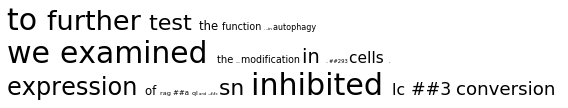

In [56]:
def attention_text(x, y, strings, alphas, orientation='horizontal',
                 ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    ax.axis('off')
    t = ax.transData
    canvas = ax.figure.canvas

    assert orientation in ['horizontal', 'vertical']
    if orientation == 'vertical':
        kwargs.update(rotation=90, verticalalignment='bottom')

    for s, alpha in zip(strings, alphas):
        text = ax.text(x, y, s + " ", size=alpha*30, transform=t, **kwargs)

        # Need to draw to update the text position.
        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        if orientation == 'horizontal':
            t = transforms.offset_copy(
                text.get_transform(), x=ex.width, units='dots')
        else:
            t = transforms.offset_copy(
                text.get_transform(), y=ex.height, units='dots')


alphas = np.arange(1,9) * 0.1
fig = plt.figure(figsize=(6, 0.3))
attention_text(0, 4, goal_string, normalize(goal_weight))
attention_text(0, 2, method_string, normalize(method_weight))
attention_text(0, 0, results_string, normalize(results_weight))
#plt.show()
filename = "attention_visualization.pdf"
plt.savefig(filename,quality=100,bbox_inches='tight')